### This is just data visualization notebook. I will gradually update and publish this notebook over time. Your kind suggestion is highly appreciated.  If you find this insightful, please upvote it. Thanks. 

## Data Format
The images are provided in DICOM format. This can be accessed using commonly-available libraries like **`pydicom`**, and contains both image and metadata. It is a commonly used medical imaging data format.

Images are also provided in ** `JPEG`** and** `TFRecord`** format (in the jpeg and tfrecords directories, respectively). Images in **`TFRecord`** format have been resized to a uniform ** `1024x1024`**.

Metadata is also provided outside of the DICOM format, in CSV files. See the Columns section for a description.

## What to predict. 
We have to predict a binary target for each image. The model model should predict the probability (floating point) between 0.0 and 1.0 that the lesion in the image is malignant (the target). In the training data, `train.csv`, the **value 0 denotes benign, and 1 indicates malignant.**

## Data Set Files
The dataset consists of images in :
* DICOM format in the directories `train` and `test`
* JPEG format in JPEG directory
* TFRecord format in tfrecords directory

Additionally, there is a metadata comprising of train, test and submission file in CSV format.
So the whole dataset looks like the following
* **jpeg(dir)**
    * test --> all the jpg images in testset
    * train --> all the jpg images in training  set
* ** test(dir)** --> all the test images in DICOM format
* **tfrecords(dir)**  --> dataset converted into TFRecords
* **train(dir)**  -->all the training images in DICOM format
* **train.csv** --> the training set metadata
* **test.csv**  -->the test set metadata
* sample_submission.csv --> a sample submission file in the correct format


## Evaluation Metrics
The metric in evaluation for this competition is AUC, that for "Area under the ROC Curve."
So lets know about ROC Curve. 
### ROC curve
An **ROC curve (receiver operating characteristic curve)** is a graph showing the performance of a classification model at all classification thresholds. Let us take the following confusion matrix. ![confusion_matrix](https://miro.medium.com/max/356/1*g5zpskPaxO8uSl0OWT4NTQ.png)
This curve plots two parameters:
* True Positive Rate
* False Positive Rate
**True Positive Rate (TPR)** is a synonym for recall and is therefore defined as follows:
$$TPR = \frac{TP}{(TP + FN)}$$

**False Positive Rate (FPR)** is defined as follows:
$$FPR =\frac{ FP}{  (FP + TN)}$$

**An ROC curve plots TPR vs. FPR at different classification thresholds**. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.
![](https://imgur.com/N3UOcBF.png)

## AUC: Area Under the ROC Curve
**AUC** stands for **"Area under the ROC Curve."**  That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).
![auc](https://imgur.com/YE18DBT.jpg =280x)
AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.


Source: [Classification: ROC Curve and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

# 1. Loading Libraries

In [1]:
!pip install -q efficientnet
!pip install -q pyyaml h5py

#basic libraries
import os, re, math
import numpy as np
import pandas as pd

#plot libraries
import matplotlib.pyplot as plt
import plotly.express as px

#utilities library
from sklearn import metrics
from sklearn.model_selection import train_test_split

#background library for learning 
import tensorflow as tf
import tensorflow.keras.layers as Layers

from kaggle_datasets import KaggleDatasets

import efficientnet.tfkeras as efn



You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
train_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

# 2. Metadata Description
### Columns of `train.csv`
* image_name - unique identifier, points to filename of related DICOM image
* patient_id - unique patient identifier
* sex - the sex of the patient (when unknown, will be blank)
* age_approx - approximate patient age at time of imaging
* anatom_site_general_challenge - location of imaged site
* diagnosis - detailed diagnosis information (train only)
* benign_malignant - indicator of malignancy of imaged lesion
* target - binarized version of the target variable

In [3]:
print('No of samples:  ' + str(train_df.image_name.nunique()))
print('No of patients: ' + str(train_df.patient_id.nunique()))

No of samples:  33126
No of patients: 2056


### No of samples taken from patients frequency
Observing the number of patients and no of total samples,I came to the follwoing insights. 

* All the patients gave at least 2 samples.
* Maximum no of sample taken from a single patient is 115.
* On an average each patient gave 16 samples
* Median of samples of image per patient is 12
* Mode of samples of image per patient is 2

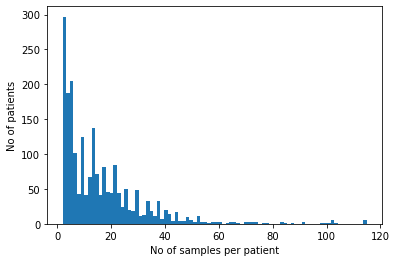

Minimum no of sample taken from  single patient 2
Maximum no of sample taken from  single patient 115
There are  16  samples taken from each patients on average
Median of no. of samples taken from  single patient 12
Mode of no. of samples taken from  single patient 3


In [4]:
image_freq_per_patient = train_df.groupby(['patient_id']).count()['image_name']
plt.hist(image_freq_per_patient.tolist(), bins = image_freq_per_patient.nunique())
plt.xlabel('No of samples per patient')
plt.ylabel('No of patients')
plt.show()
print('Minimum no of sample taken from  single patient', image_freq_per_patient.min())
print('Maximum no of sample taken from  single patient', image_freq_per_patient.max())
print('There are ',int( image_freq_per_patient.mean()), ' samples taken from each patients on average')
print('Median of no. of samples taken from  single patient', int(image_freq_per_patient.median()))
print('Mode of no. of samples taken from  single patient', int(image_freq_per_patient.mode()))


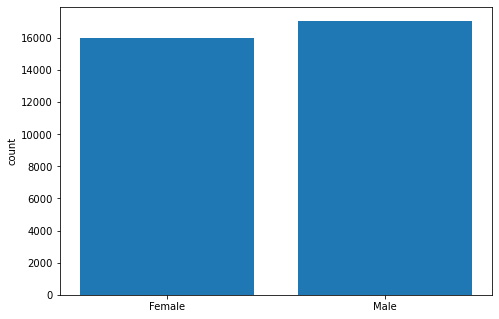

sex
female    15981
male      17080
Name: image_name, dtype: int64

In [5]:
sex_count = train_df.groupby(['sex']).count()['image_name']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['Female', 'Male'], sex_count)
plt.ylabel('count')
plt.show()
sex_count

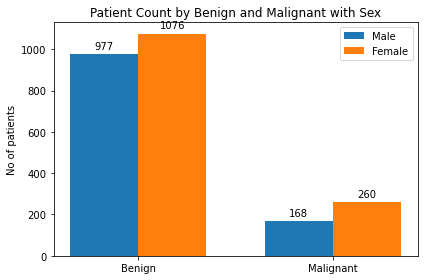

In [6]:
category_sex = train_df.groupby(['sex', 'benign_malignant']).nunique()['patient_id'].tolist()

labels = ['Benign', 'Malignant']
benign_data = category_sex[0:2]
maglignant_data = category_sex[2:4]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_data, width, label='Male')
rects2 = ax.bar(x + width/2, maglignant_data, width, label='Female')
ax.set_ylabel('No of patients')
ax.set_title('Patient Count by Benign and Malignant with Sex')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

Here we observe that among the unique patients providing samples, 
* **Melanoma is more prevalant in Women** 
* **Among the Male patients, almost 24% are at malignant stage**
* **On the other hand, among Femele patients, about 17% are at malignant stage**

In [7]:
train_df.groupby(['benign_malignant', 'sex']).nunique()['patient_id']

benign_malignant  sex   
benign            female     977
                  male      1076
malignant         female     168
                  male       260
Name: patient_id, dtype: int64

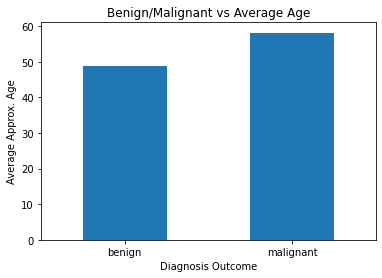

In [8]:
plt.figure()
train_df.groupby(['benign_malignant']).mean()['age_approx'].plot.bar(x = 'Diagnosis Type', y = 'Average age', rot = 0)
plt.title('Benign/Malignant vs Average Age')
plt.xlabel('Diagnosis Outcome')
plt.ylabel('Average Approx. Age')
plt.show()

Here we see that comparatively malignant patients are of higher age and their average age is almost 57 years whereas average age of the benign patients is close to 50. 

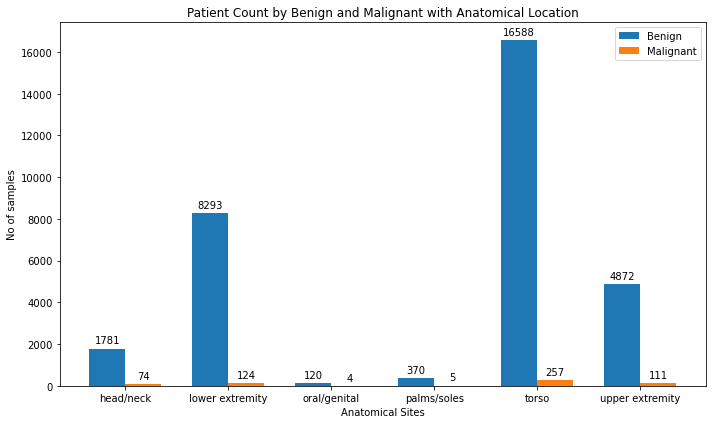

In [9]:
site_vs_diagnosis = train_df.groupby(['anatom_site_general_challenge', 'benign_malignant']).count()['patient_id'].tolist()
labels = ['head/neck', 'lower extremity', 'oral/genital','palms/soles', 'torso', 'upper extremity']
benign_data = site_vs_diagnosis[0:12:2]
maglignant_data = site_vs_diagnosis[1:12:2]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6))
rects1 = ax.bar(x - width/2, benign_data, width, label='Benign')
rects2 = ax.bar(x + width/2, maglignant_data, width, label='Malignant')
ax.set_ylabel('No of samples')
ax.set_xlabel('Anatomical Sites')
ax.set_title('Patient Count by Benign and Malignant with Anatomical Location')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


**So the above graph says that oral/genital and palms/soles are least likely to develop Melanoma disease whereas most of the time torso develops melanoma**


# 4. TPU Setup Code

In [10]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# 5. Setting up Running Configuration 

In [11]:
# For tf.dataset Tensorflow tf. data AUTOTUNE. ... prefetch transformation, 
# which can be used to decouple the time when data is produced from the time when data is consumed. 
# In particular, the transformation uses a background thread and an internal buffer to prefetch 
# elements from the input dataset ahead of the time they are requested.
AUTO = tf.data.experimental.AUTOTUNE

# Get data access to the dataset for TPUs
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

# Running Configuration 
EPOCHS = 15
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]

# Listing the filenames in TFRecords fomat
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')
CLASSES = [0,1]
print('Training filenames\n', TRAINING_FILENAMES)
print('Test file names\n', TEST_FILENAMES)

Training filenames
 ['gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train00-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train01-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train02-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train03-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train04-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train05-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train06-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train07-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train08-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train09-2071.tfrec',

# 6. Training Validation Split

In [12]:
VALIDATION_FILENAMES =list(pd.Series(TRAINING_FILENAMES)[[0,1,2]])
TRAINING_FILENAMES = list(pd.Series(TRAINING_FILENAMES)[[3,4,5,6,7,8,9,10,11,12,13,14,15]])
print(TRAINING_FILENAMES)
print(VALIDATION_FILENAMES)

['gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train03-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train04-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train05-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train06-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train07-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train08-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train09-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train10-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train11-2071.tfrec', 'gs://kds-0b2c68d2b2fa4692fcffc1029c606b32dd6a88de8d6da08fcd30d0c4/tfrecords/train12-2071.tfrec', 'gs://kds-0b2c68d2b

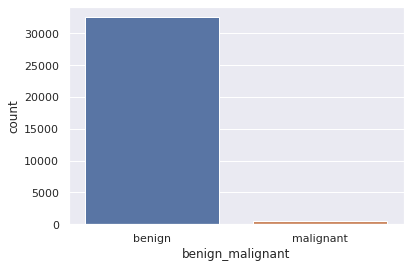

In [13]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(train_df['benign_malignant'])

# 6. Helper Functions

In [14]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        #"class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    #label = tf.cast(example['class'], tf.int32)
    label = tf.cast(example['target'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset


def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# 7. Data Augmentation 

In [15]:
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (above),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

# 8. Data Sumamry

Dataset Details:
26913 training images,  
6213 validation images 
10982 unlabeled test images


<Figure size 432x288 with 0 Axes>

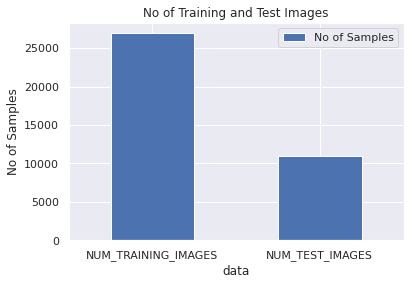

In [16]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
NUM_VALID_IMAGES = count_data_items(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset Details:\n{} training images,  \n{} validation images \n{} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALID_IMAGES, NUM_TEST_IMAGES))


df = pd.DataFrame({'data':['NUM_TRAINING_IMAGES', 'NUM_TEST_IMAGES'],
                   'No of Samples':[NUM_TRAINING_IMAGES, NUM_TEST_IMAGES]})
plt.figure()
x = df.plot.bar(x='data', y='No of Samples', rot=0)
plt.ylabel('No of Samples')
plt.title('No of Training and Test Images')
plt.show()

# 9. Learning Rate Scheduler

In [17]:
def build_lrfn(lr_start=0.000002, lr_max=0.00010, 
               lr_min=0, lr_rampup_epochs=8, 
               lr_sustain_epochs=1, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [18]:
model_checkpoint_callback_efnB0 = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_efnB0_best_val_acc.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_efnB1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_efnB1_best_val_acc.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_efnB3 = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_efnB3_best_val_auc.hdf5',
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

# 10. Training Models

## EfficentNetB5 

In [19]:
# with strategy.scope():
#     model0 = tf.keras.Sequential([
#         efn.EfficientNetB5(
#             input_shape=(*IMAGE_SIZE, 3),
#             #weights='noisy-student',
#             weights='imagenet',
#             include_top=False
#         ),
#         Layers.GlobalAveragePooling2D(),
#         Layers.Dense(1024, activation = 'relu'), 
#         Layers.Dropout(0.3), 
#         Layers.Dense(512, activation= 'relu'), 
#         Layers.Dropout(0.2), 
#         Layers.Dense(256, activation='relu'), 
#         Layers.Dropout(0.2), 
#         Layers.Dense(128, activation='relu'), 
#         Layers.Dropout(0.1), 
#         Layers.Dense(1, activation='sigmoid')
#     ])
    
# model0.compile(
#     optimizer='adam',
#     loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
#     metrics=['binary_crossentropy']
# )
# model0.summary()

## EfficentNetB7

In [20]:
# with strategy.scope():
#     model1 = tf.keras.Sequential([
#         efn.EfficientNetB7(
#             input_shape=(*IMAGE_SIZE, 3),
#             weights='imagenet',
#             include_top=False
#         ),
#         Layers.GlobalAveragePooling2D(),
#         Layers.Dense(1, activation='sigmoid')
#     ])
#     model1.compile(
#         optimizer='adam',
#         loss = 'binary_crossentropy',
#         metrics=['accuracy']
#     )
#     model1.summary()
    

## EfficentNetB0

In [21]:
with strategy.scope():
    model_efn_b0 = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        Layers.GlobalAveragePooling2D(),
        Layers.Dense(1, activation='sigmoid')
    ])
    model_efn_b0.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    model_efn_b0.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 32, 32, 1280)      4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________


# EfficentNetB1

In [22]:
# with strategy.scope():
#     model_efn_b1 = tf.keras.Sequential([
#         efn.EfficientNetB1(
#             input_shape=(*IMAGE_SIZE, 3),
#             weights='imagenet',
#             include_top=False
#         ),
#         Layers.GlobalAveragePooling2D(),
#         Layers.Dense(1, activation='sigmoid')
#     ])
#     model_efn_b1.compile(
#         optimizer='adam',
#         loss = 'binary_crossentropy',
#         metrics=['accuracy']
#     )
#     model_efn_b1.summary()

# EfficentNetB3

In [23]:
# with strategy.scope():
#     model_efn_b3 = tf.keras.Sequential([
#         efn.EfficientNetB3(
#             input_shape=(*IMAGE_SIZE, 3),
#             #weights='imagenet',
#             weights='imagenet',
#             include_top=False
#         ),
#         Layers.GlobalAveragePooling2D(),
#         Layers.Dense(512, activation='relu'),
#         Layers.Dense(128, activation='relu'),
#         Layers.Dense(1, activation='sigmoid')
#     ])
    
# model_efn_b3.compile(
#     optimizer='adam',
#     loss = 'binary_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.AUC()]
# )
# model_efn_b3.summary()

## DenseNet201

In [24]:
# from tensorflow.keras.applications import DenseNet201
# with strategy.scope():
#     dnet201 = DenseNet201(
#         input_shape=(*IMAGE_SIZE, 3),
#         weights='imagenet',
#         include_top=False
#     )
#     dnet201.trainable = True

#     model3 = tf.keras.Sequential([
#         dnet201,
#         Layers.GlobalAveragePooling2D(),
#         Layers.Dense(1, activation='sigmoid')
#     ])
#     model3.compile(
#         optimizer='adam',
#         loss = 'binary_crossentropy',
#         metrics=['accuracy']
#     )
# model3.summary()

In [25]:
# history = model1.fit(
#     get_training_dataset(), 
#     epochs=2, 
#     callbacks=[lr_schedule],
#     steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE
#     #validation_data=valid_dataset
# )

In [26]:
# tf.tpu.experimental.initialize_tpu_system(tpu)

In [27]:

model_efn_b0.load_weights('/kaggle/input/melanoma-pretrained/model_efnB0_best_val_acc(just_5_epoch_895).hdf5')
# history_efn_b0 = model_efn_b0.fit(
#     get_training_dataset(), 
#     epochs=5, 
#     callbacks=[lr_schedule, model_checkpoint_callback_efnB0],
#     steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE,
#     validation_data=get_validation_dataset()
# )

In [28]:
# model_efn_b0.load_weights('/kaggle/working/model_efnB0_best_val_acc.hdf5')

In [29]:
# history_efn_b1 = model_efn_b1.fit(
#     get_training_dataset(), 
#     epochs=5, 
#     callbacks=[lr_schedule, model_checkpoint_callback_efnB1],
#     steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE,
#     validation_data=get_validation_dataset()
# )

In [30]:
# model_efn_b1.load_weights('/kaggle/working/model_efnB1_best_val_acc.hdf5')

In [31]:
# history_efn_b3 = model_efn_b3.fit(
#     get_training_dataset(), 
#     epochs=EPOCHS, 
#     callbacks=[lr_schedule, model_checkpoint_callback_efnB3],
#     steps_per_epoch=NUM_TRAINING_IMAGES // BATCH_SIZE,
#     validation_data=get_validation_dataset()
# )

In [32]:
# model_efn_b3.load_weights('/kaggle/working/model_efnB3_best_val_auc.hdf5')

# 11. Prediction and Submission Generation

In [33]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model_efn_b0.predict(test_images_ds)


print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()


del sub['target']
sub = sub.merge(pred_df, on='image_name')
sub.to_csv('submission_label_smoothing.csv', index=False)
sub.to_csv('submission.csv', index=False)
sub.head()

Computing predictions...
Generating submission.csv file...


,image_name,target
0,ISIC_0052060,0.009566
1,ISIC_0052349,0.000166
2,ISIC_0058510,0.000350
3,ISIC_0073313,0.000111
4,ISIC_0073502,0.047736
